In [1]:
import os
import random
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import torch

from utils.dl.niab import InstanceDataset, IMG_TRANSFORMS, MASK_TRANSFORMS

from torch.utils.data import DataLoader
from utils.dl.loss import DiscriminativeLoss

/home/users/ashine/miniconda3/envs/niab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Size of dataset: 67
Image shape: torch.Size([1, 256, 256])
Unique values in binary mask: tensor([0., 1.])
Unique values in instance mask: tensor([0, 1, 2, 3, 4, 5, 6, 7])


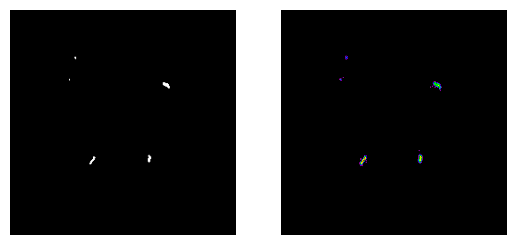

In [2]:
dummy_dataset = InstanceDataset(
    "../datasets/dummy_instance/binary_masks", 
    "../datasets/dummy_instance/instance_masks",
    img_transform=IMG_TRANSFORMS, mask_transform=MASK_TRANSFORMS
)

# Could change the dimention to be 512 (512/16=32 (given that 2^5=32 and resnet34 has 5 layers of downsampling by a factor of 2))

random_index = random.randint(0, len(dummy_dataset) - 1)
binary_mask, instance_mask = dummy_dataset[random_index]

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(binary_mask.permute(1, 2, 0), cmap='gray')  # permute to change the order of the channels so that it can be displayed correctly
plt.axis('off')

# Plot mask
plt.subplot(1, 2, 2)
plt.imshow(instance_mask.permute(1, 2, 0), cmap='nipy_spectral')
plt.axis('off')

print(f"Size of dataset: {len(dummy_dataset)}")
print(f"Image shape: {binary_mask.shape}")

# TODO: Be sure that the segmentation masks are binary and not RGB
# I am pretty sure at the moment that the masks are RGB as they are a jpeg image and not a png image - I need to convert them to greyscale
print(f"Unique values in binary mask: {torch.unique(binary_mask)}")
print(f"Unique values in instance mask: {torch.unique(instance_mask)}")

plt.show()

In [3]:
# Split the dataset into training and validation sets
total_size = len(dummy_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
training_dataset, validation_dataset = random_split(dummy_dataset, [train_size, val_size])

# How much data?
print(f"Size of training dataset: {len(training_dataset)}")
print(f"Size of validation dataset: {len(validation_dataset)}")

# Post-transformation, what does the data look like?
print(f"Shape of first input entry (post-transformation): {dummy_dataset[0][0].shape}")
print(f"Shape of first label entry (post-transformation): {dummy_dataset[0][1].shape}")

Size of training dataset: 53
Size of validation dataset: 14
Shape of first input entry (post-transformation): torch.Size([1, 256, 256])
Shape of first label entry (post-transformation): torch.Size([1, 256, 256])


In [5]:
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y) ** 2, dim=1))

def cosine_distance(x, y):
    x_norm = F.normalize(x, p=2, dim=1)
    y_norm = F.normalize(y.float(), p=2, dim=1)
    return 1 - torch.sum(x_norm * y_norm, dim=1)

def discriminative_loss(embeddings, target_masks, delta_var=0.5, delta_dist=1.5, distance_fn=euclidean_distance):
    # Compute the pairwise distances between embeddings
    dist_mat = distance_fn(embeddings[:, None, :], embeddings[None, :, :])

    # Compute the size-invariant delta_var and delta_dist
    delta_var = delta_var * dist_mat.max()
    delta_dist = delta_dist * dist_mat.max()

    # Compute the instance-based loss
    inst_loss = torch.sum(delta_dist * torch.max(delta_var - dist_mat, torch.zeros_like(dist_mat))) / (dist_mat.shape[0] * dist_mat.shape[1])

    # Compute the variation loss
    variation_loss = torch.sum(torch.max(dist_mat - delta_dist, torch.zeros_like(dist_mat))) / (dist_mat.shape[0] * dist_mat.shape[1])

    # Combine the losses
    loss = inst_loss + variation_loss

    return loss

def contrastive_loss(outputs, labels, margin=1.0):
    # Compute pairwise distance matrix
    dist_matrix = torch.cdist(outputs, outputs, p=2)

    # Create a binary matrix where 1 indicates different classes and 0 indicates same class
    labels_matrix = labels.unsqueeze(1) != labels.unsqueeze(0)

    # Create a binary matrix where 1 indicates background class and 0 indicates other classes
    background_matrix = labels.unsqueeze(1) == 0

    # Compute the loss for pairs of instances from different classes
    pos_pair_loss = torch.sum(dist_matrix * labels_matrix.float() * (1 - background_matrix.float()))

    # Compute the loss for pairs of instances from the same class
    neg_pair_loss = torch.sum(torch.clamp(margin - dist_matrix, min=0) * (1 - labels_matrix.float()) * (1 - background_matrix.float()))

    # Compute the loss for pairs of instances from the background class
    background_loss = torch.sum(dist_matrix * background_matrix.float())

    # Combine the three losses
    loss = pos_pair_loss + neg_pair_loss + background_loss

    return loss

In [13]:
BATCH_SIZE = 2 ** 4  # should be divisible by the training dataset size
EPOCHS = 70

# class CustomUnet(smp.Unet):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.embeddings = None

#     def forward(self, x):
#         features = super().forward(x)
#         self.embeddings = features[-1]  # Extract the final feature map as embeddings
#         return features  # Return the original output for compatibility

device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training/fitting using {device} device")

# Create a data loader to handle loading data in and out of memory in batches
train_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Look at the shape of the data coming out of the data loader (batch size, channels, height, width)
for X, y in validation_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Create an instance of the model and move it to the device (GPU or CPU)
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=20,                      # model output channels (number of classes in your dataset)
).to(device)

def fit(dataloader, model, loss_fn, optimizer, scheduler, device, log_freq=10) -> None:
    """
    Fit the model to the data using the loss function and optimizer
    Taken from the official PyTorch quickstart tutorial (https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html#optimizing-the-model-parameters)
    :param dataloader:
    :param model:
    :param loss_fn:
    :param optimizer:
    :param scheduler:
    :param device:
    :param log_freq:
    :return: None
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # move data to device (GPU or CPU), ensure that the data and model are on the same device
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)  # forward pass
        embeddings = model.embeddings  # Retrieve the embeddings from the model
        loss = loss_fn(embeddings, y)  # Compute discriminative loss

        # Backpropagation
        loss.backward()  # backward pass (calculate gradients)
        optimizer.step()  # update params
        optimizer.zero_grad()  # reset gradients to zero

        # To avoid too much output, only print every n batches (log_freq), by default every 10 batches
        if batch % log_freq == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def validate(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            embeddings = model.embeddings  # Retrieve the embeddings from the model
            total_loss += loss_fn(embeddings, y).item()  # Compute discriminative loss

    # Calculate averages
    avg_loss = total_loss / num_batches

    print(f"Validation Metrics: Avg loss: {avg_loss:>8f}")
    return avg_loss

# loss_fn = smp.losses.SoftCrossEntropyLoss(
#     reduction="mean",
#     smooth_factor=0.1,
# )
# loss_fn = discriminative_loss
criterion_disc = DiscriminativeLoss(delta_var=0.5,
                                    delta_dist=1.5,
                                    norm=2,
                                    usegpu=True)

optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4) # high learning rate and allow it to decay

best_loss = float('inf')
for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    fit(train_dataloader, model, loss_fn, optimizer, None, device, log_freq=2)
    val_loss = validate(validation_dataloader, model, loss_fn)
    if val_loss < best_loss:
        best_loss = val_loss
print("Done!")

Training/fitting using cuda device
Shape of X: torch.Size([14, 1, 256, 256])
Shape of y: torch.Size([14, 1, 256, 256]) torch.int64
Epoch 1
-------------------------------
loss: 740034.375000  [   16/   53]
loss: 1072066.375000  [   48/   53]
Validation Metrics: Avg loss: 3463832.250000
Epoch 2
-------------------------------
loss: 434866.906250  [   16/   53]
loss: 330962.406250  [   48/   53]
Validation Metrics: Avg loss: 3503902.000000
Epoch 3
-------------------------------
loss: 296865.187500  [   16/   53]
loss: 569893.187500  [   48/   53]
Validation Metrics: Avg loss: 6273710.000000
Epoch 4
-------------------------------
loss: 245864.156250  [   16/   53]
loss: 166352.531250  [   48/   53]
Validation Metrics: Avg loss: 10746979.000000
Epoch 5
-------------------------------
loss: 138419.406250  [   16/   53]
loss: 129156.578125  [   48/   53]
Validation Metrics: Avg loss: 13489936.000000
Epoch 6
-------------------------------
loss: 104471.617188  [   16/   53]
loss: 72987.3984

Unique values in prediction: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19], device='cuda:0')


(-0.5, 255.5, 255.5, -0.5)

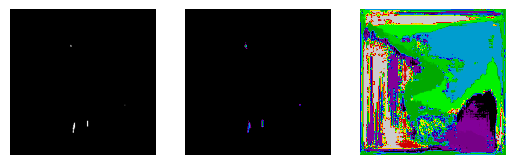

In [14]:
# plot the results of the multi-class segmentation
model.eval()
for X, y in validation_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    # unique values in the prediction
    print(f"Unique values in prediction: {torch.unique(pred.argmax(dim=1))}")
    break

# Plot the image
plt.subplot(1, 3, 1)
plt.imshow(X[0].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')

# Plot the ground truth
plt.subplot(1, 3, 2)
plt.imshow(y[0].cpu().permute(1, 2, 0).squeeze(), cmap='nipy_spectral')
plt.axis('off')

# Plot the prediction
plt.subplot(1, 3, 3)
plt.imshow(pred[0].cpu().argmax(dim=0).detach().numpy(), cmap='nipy_spectral')
plt.axis('off')

Unique values in prediction: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19], device='cuda:0')


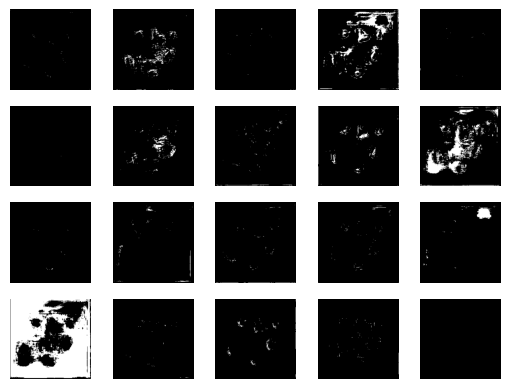

In [41]:
# forwards pass 
model.eval()
with torch.no_grad():
    pred = model(binary_mask.unsqueeze(0).to(device))
    print(f"Unique values in prediction: {torch.unique(pred.argmax(dim=1))}")

# plot each instance in the prediction
for i in range(1, 21):
    plt.subplot(4, 5, i)
    plt.imshow(pred[0].cpu().argmax(dim=0).detach().numpy() == i, cmap='gray')
    plt.axis('off')